In [11]:
# Libraries

import torch
import torchvision
import re
import os
import glob
import sys
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from scipy import io

from networks import SegNet
from mappings import mapping
from load_sunrgbd_dataset import load_dataset
from EarlyStopping import EarlyStopping

# Constant variables
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LR = 0.001  
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 14
IMG_SIZE = (400, 400)
# Paths

CHECKPOINT_DIR = '/home4/shubham/MTML_Pth/checkpoints/'
VIS_RESULTS_PATH = '/home4/shubham/MTML_Pth/results/'

In [12]:
class DatasetLoader(Dataset):
    
    def __init__(self, data, ground_truth, transform = None):
        self.data = data
        self.gt = ground_truth
        self.length = len(data)
        self.transform = transform

    def __len__(self):
        return self.length
  
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        img = img.resize(IMG_SIZE, Image.BILINEAR)
        gt = Image.open(self.gt[idx])
        gt = gt.resize(IMG_SIZE, Image.NEAREST)
        
        if self.transform:
            img, gt = self.transform(img, gt)
            gt = np.array(gt)
            
        return img, gt



In [13]:
class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)

    def get_metrics(self):
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu), acc
    

In [14]:
def train_loop(model, tloader, vloader, criterion, optimizer):
    """
    returns loss and accuracy of the model for 1 epoch.
    params: model -  vgg16
          tloader - train dataset
          vloader - val dataset
          criterion - loss function
          optimizer - Adam optimizer
    """
    total = 0
    correct = 0
    train_losses = []
    valid_losses = []
    t_mean_iou = []
    v_mean_iou = []
    
    model.train()
    model.to(DEVICE)
    train_cm = ConfMatrix(OUTPUT_CHANNELS)
    test_cm = ConfMatrix(OUTPUT_CHANNELS)
    
    for ind, (image, label) in enumerate(tloader):
     
        image = image.to(DEVICE)
        label = label.type(torch.LongTensor)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()

        output, _ = model(image)
        
        loss = criterion(output, torch.squeeze(label,1))
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        pred_values, predicted = torch.max(output, 1)
        train_cm.update(predicted, label)
       
    
    t_epoch_iou, train_accuracy = train_cm.get_metrics()    
    t_epoch_loss = np.average(train_losses)
    

    total = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for ind, (image, label) in enumerate(vloader):
            image = image.to(DEVICE)
            label = label.type(torch.LongTensor)
            label = label.to(DEVICE)
            output,_ = model(image)
            loss = criterion(output, torch.squeeze(label,1))
            pred_values, predicted = torch.max(output, 1)
            test_cm.update(predicted, label)
            valid_losses.append(loss.item())
            
            if ind == 0:
                fig = plt.figure(figsize=(11,11))
                ax = plt.subplot(1, 3, 1)
                plt.imshow(image[0].cpu().numpy().transpose((1, 2, 0)))
                ax = plt.subplot(1, 3, 2)
                plt.imshow(torch.squeeze(label[0].cpu(),0))
                ax = plt.subplot(1, 3, 3)
                plt.imshow(predicted[0].cpu())
                plt.show()
                fig2 = plt.figure(figsize=(11,11))
                ax = plt.subplot(1, 3, 1)
                plt.imshow(image[1].cpu().numpy().transpose((1, 2, 0)))
                ax = plt.subplot(1, 3, 2)
                plt.imshow(torch.squeeze(label[1].cpu(),0))
                ax = plt.subplot(1, 3, 3) 
                plt.imshow(predicted[1].cpu())
                plt.show()
    
    v_epoch_loss = np.average(valid_losses)
    v_epoch_iou, val_accuracy = test_cm.get_metrics() 
    
    return model, t_epoch_loss, v_epoch_loss, train_accuracy, val_accuracy, t_epoch_iou, v_epoch_iou



In [15]:
def train_model(trainloader, valloader):
    """
    returns losses (train and val), accuracies (train and val), trained_model
    params: trainloader = train dataset
            valloader = validation dataset
    """
    
    model = SegNet(INPUT_CHANNELS, OUTPUT_CHANNELS).to(DEVICE)
    
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    early_stop = EarlyStopping(patience=7)
    
    for epoch in range(EPOCHS):
        print("Running Epoch {}".format(epoch+1))

        model, epoch_train_loss,  epoch_val_loss, train_ac, val_ac, train_iou, val_iou = train_loop( model, trainloader, valloader, criterion, optimizer)
        train_loss.append(epoch_train_loss)   
        val_loss.append(epoch_val_loss)
        train_acc.append(train_ac)
        val_acc.append(val_ac)

        print("Training loss: {0:.4f}   Training accuracy: {1:.4f}   Training mIoU: {2:.4f}".format(epoch_train_loss, train_ac, train_iou))
        print("Validation loss: {0:.4f} Validation accuracy: {1:.4f} Validation mIoU: {2:.4f}".format(epoch_val_loss, val_ac, val_iou))
        print("--------------------------------------------------------")
        
        early_stop(epoch_val_loss, model)
    
        if early_stop.early_stop:
            print("Early stopping")
            break 

        if (epoch+1)%5 == 0:
            torch.save(model.state_dict(), CHECKPOINT_DIR + "/sun_segnet_epoch_" + str(epoch+1) + ".pth")

    print("Training completed!")
    losses = [train_loss, val_loss]
    accuracies = [train_acc, val_acc]
    
    return losses, accuracies, model



In [28]:
def run_inference(testloader):
    """
    returns performance of the model on test dataset
    """
    correct, total = 0, 0
    model = SegNet(INPUT_CHANNELS, OUTPUT_CHANNELS).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    v_mean_iou = []
    valid_losses = []
    model.eval()
    print("Loading pre-trained weights...")
    final_model_path = CHECKPOINT_DIR+'sun_early_stopping_sgd_segmentation_model.pth'
    model.load_state_dict(torch.load(final_model_path))
    print("Weights loaded!")
    test_cm = ConfMatrix(OUTPUT_CHANNELS)
    
    with torch.no_grad():
        for ind, (image, label) in enumerate(testloader):
            image = image.to(DEVICE)
            label = label.type(torch.LongTensor)
            label = label.to(DEVICE)
            output,_ = model(image)
            pred_values, predicted = torch.max(output, 1)
            test_cm.update(predicted, label)
            
            for i in range(0):
                fig = plt.figure(figsize=(11,11))
                ax = plt.subplot(1, 3, 1)
                plt.imshow(image[i].cpu().numpy().transpose((1, 2, 0)))
                ax = plt.subplot(1, 3, 2)
                plt.imshow(torch.squeeze(label[i].cpu(),0))
                ax = plt.subplot(1, 3, 3)
                plt.imshow(predicted[i].cpu())
                plt.show()
                if i == 0:
                    break
        
        iou, accuracy = test_cm.get_metrics()
        print("Mean Pixel IoU: ",iou)
        print("Accuracy: ",accuracy)
   
    

def train_transformation(image, gt):
    
    p = np.random.uniform(0, 1)
    
    if p <= 0.5 :
        img_out = image.transpose(Image.FLIP_LEFT_RIGHT)
        img = torchvision.transforms.ToTensor()(img_out)
        gt = gt.transpose(Image.FLIP_LEFT_RIGHT)
        
    else:
        img = torchvision.transforms.ToTensor()(image)
    
    return img, gt


def test_transformation(image, gt):
    img = torchvision.transforms.ToTensor()(image)
    return img, gt


def get_data_loader(data, label, flag):
    """
    returns train/test/val dataloaders
    params: flag = train/test/val
    """
    if flag == "train":
        dataset = DatasetLoader(data, label, transform=train_transformation) 
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
    
    else:
        dataset = DatasetLoader(data, label, transform=test_transformation)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
    
    return dataloader


def draw_training_curves(train_losses, test_losses,curve_name):
    plt.clf()
   
    plt.plot(train_losses, label='Training {}'.format(curve_name))
    plt.plot(test_losses, label='Testing {}'.format(curve_name))
    plt.legend(frameon=False)
    plt.savefig(VIS_RESULTS_PATH + "/{}_sun_segmentation.png".format(curve_name))
    

In [17]:

data, labels = load_dataset()
train_loader = get_data_loader(data["train"], labels["train"], "train")
val_loader = get_data_loader(data["val"], labels["val"], "val")
test_loader = get_data_loader(data["test"], labels["test"], "test")

Running Epoch 1


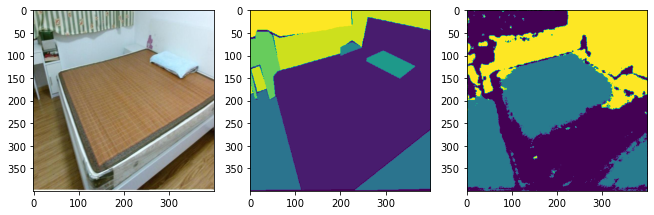

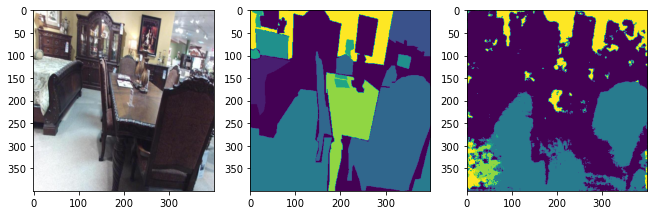

Training loss: 1.8110   Training accuracy: 0.4162   Training mIoU: 0.0816
Validation loss: 1.7009 Validation accuracy: 0.4468 Validation mIoU: 0.0880
--------------------------------------------------------
Running Epoch 2


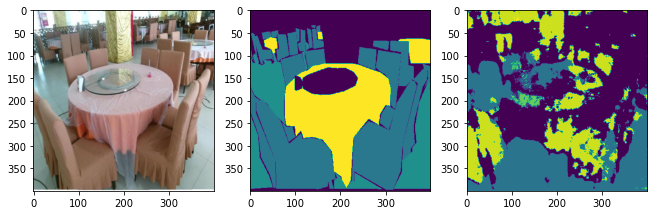

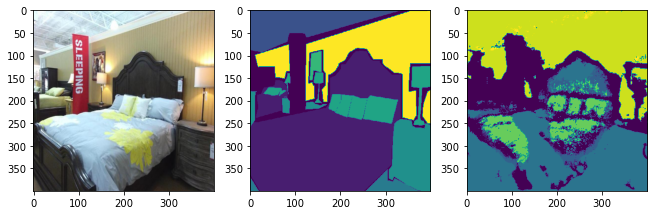

Training loss: 1.6416   Training accuracy: 0.4670   Training mIoU: 0.1074
Validation loss: 1.5721 Validation accuracy: 0.4825 Validation mIoU: 0.1081
--------------------------------------------------------
Running Epoch 3


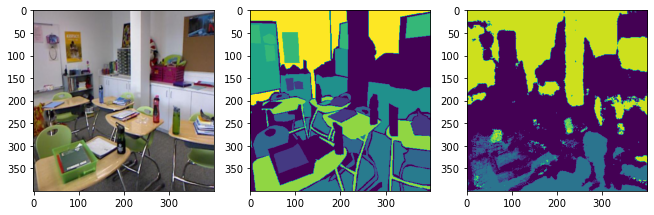

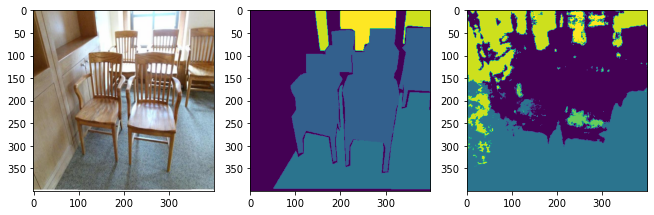

Training loss: 1.5796   Training accuracy: 0.4831   Training mIoU: 0.1200
Validation loss: 1.5178 Validation accuracy: 0.4911 Validation mIoU: 0.1156
--------------------------------------------------------
Running Epoch 4


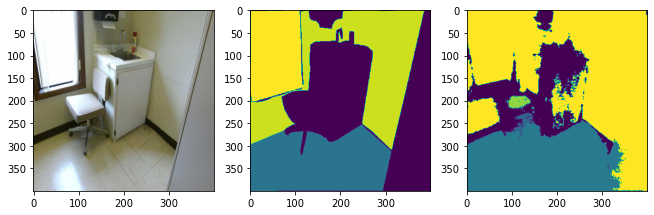

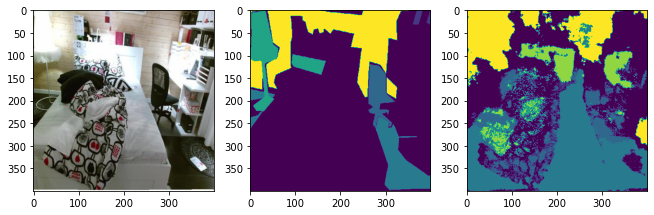

Training loss: 1.5375   Training accuracy: 0.4944   Training mIoU: 0.1280
Validation loss: 1.5287 Validation accuracy: 0.4971 Validation mIoU: 0.1257
--------------------------------------------------------
Running Epoch 5


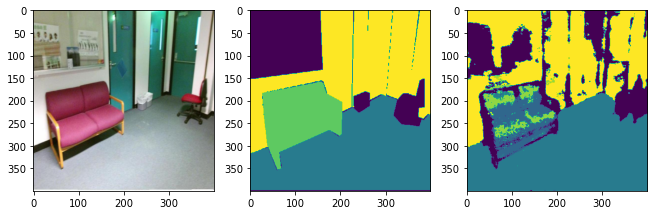

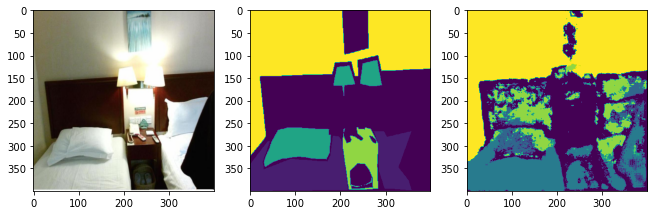

Training loss: 1.4958   Training accuracy: 0.5058   Training mIoU: 0.1359
Validation loss: 1.4701 Validation accuracy: 0.5114 Validation mIoU: 0.1294
--------------------------------------------------------
Running Epoch 6


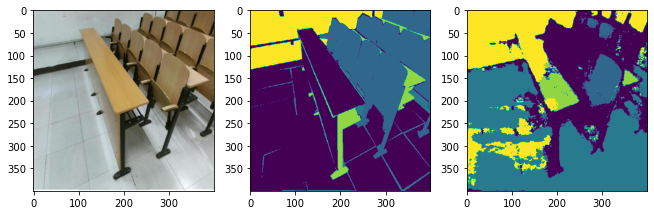

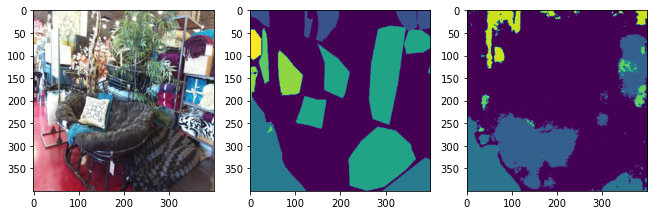

Training loss: 1.4539   Training accuracy: 0.5163   Training mIoU: 0.1449
Validation loss: 1.4178 Validation accuracy: 0.5294 Validation mIoU: 0.1441
--------------------------------------------------------
Running Epoch 7


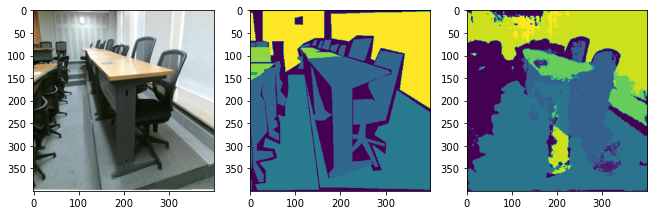

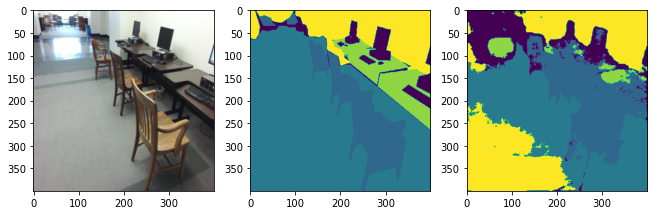

Training loss: 1.4182   Training accuracy: 0.5279   Training mIoU: 0.1581
Validation loss: 1.3687 Validation accuracy: 0.5399 Validation mIoU: 0.1782
--------------------------------------------------------
Running Epoch 8


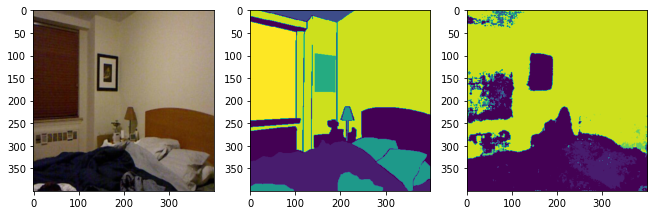

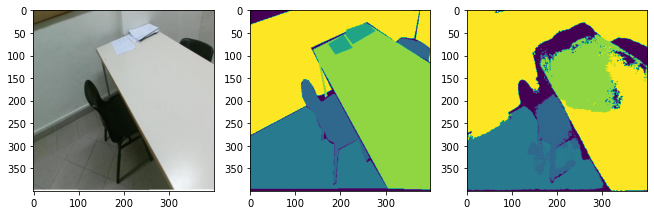

Training loss: 1.3713   Training accuracy: 0.5401   Training mIoU: 0.1779
Validation loss: 1.3172 Validation accuracy: 0.5502 Validation mIoU: 0.1886
--------------------------------------------------------
Running Epoch 9


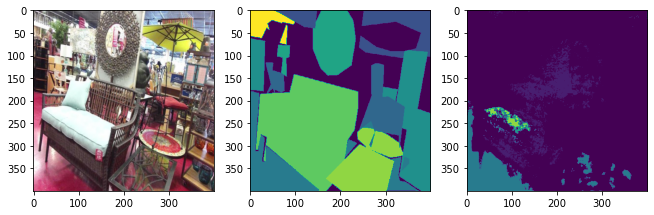

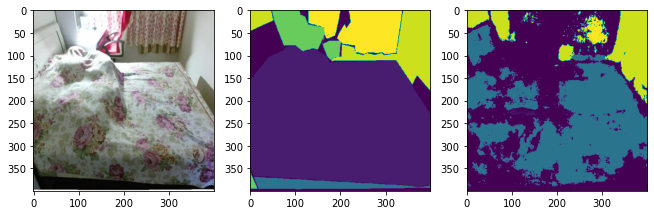

Training loss: 1.3344   Training accuracy: 0.5497   Training mIoU: 0.1982
Validation loss: 1.3086 Validation accuracy: 0.5534 Validation mIoU: 0.1926
--------------------------------------------------------
Running Epoch 10


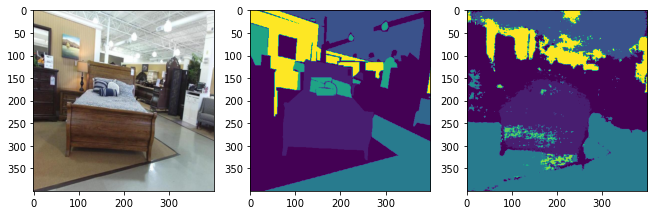

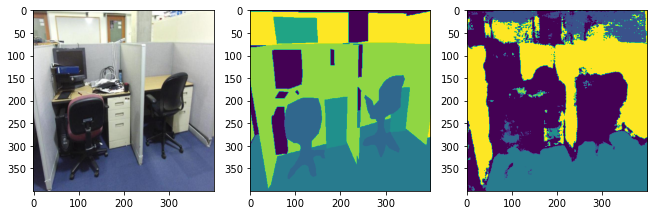

Training loss: 1.2991   Training accuracy: 0.5611   Training mIoU: 0.2126
Validation loss: 1.2374 Validation accuracy: 0.5734 Validation mIoU: 0.2343
--------------------------------------------------------
Running Epoch 11


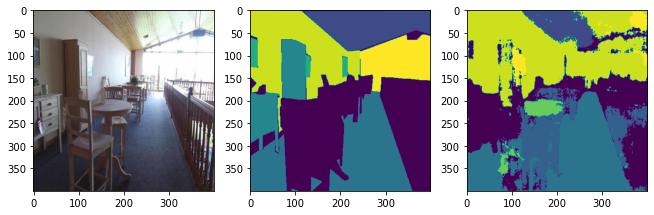

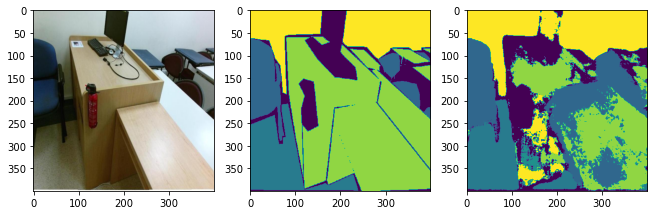

Training loss: 1.2619   Training accuracy: 0.5709   Training mIoU: 0.2290
Validation loss: 1.2725 Validation accuracy: 0.5627 Validation mIoU: 0.2370
--------------------------------------------------------
Running Epoch 12


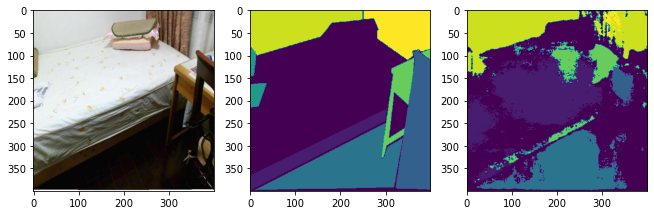

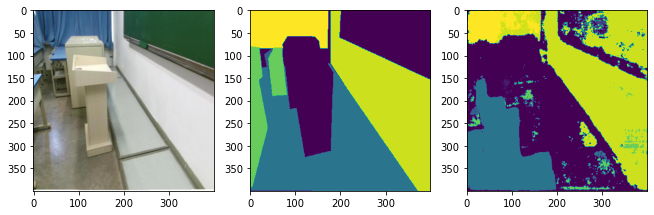

Training loss: 1.2424   Training accuracy: 0.5760   Training mIoU: 0.2420
Validation loss: 1.3129 Validation accuracy: 0.5553 Validation mIoU: 0.2245
--------------------------------------------------------
Running Epoch 13


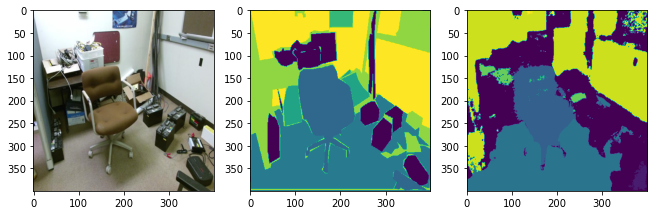

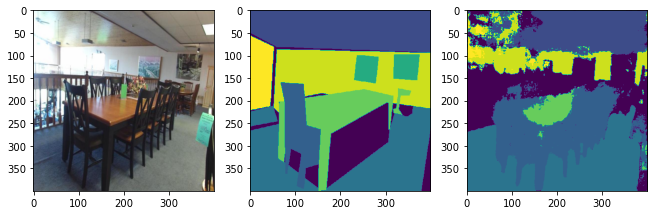

Training loss: 1.2095   Training accuracy: 0.5857   Training mIoU: 0.2549
Validation loss: 1.1839 Validation accuracy: 0.5968 Validation mIoU: 0.2682
--------------------------------------------------------
Running Epoch 14


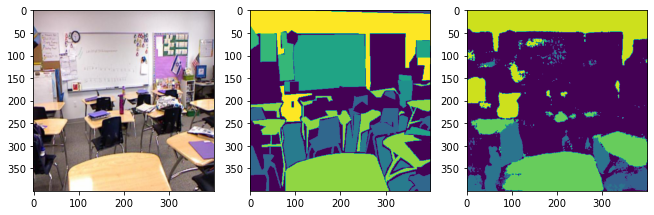

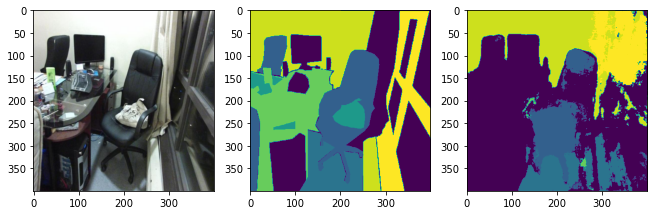

Training loss: 1.1931   Training accuracy: 0.5902   Training mIoU: 0.2650
Validation loss: 1.2006 Validation accuracy: 0.5938 Validation mIoU: 0.2567
--------------------------------------------------------
Running Epoch 15


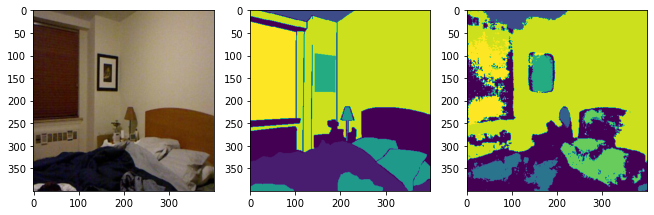

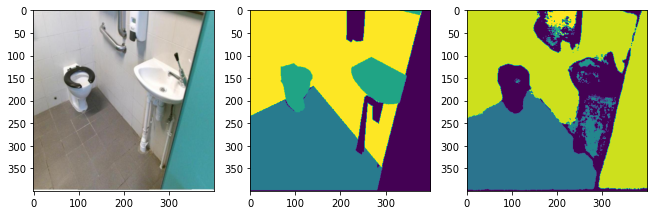

Training loss: 1.1665   Training accuracy: 0.5993   Training mIoU: 0.2768
Validation loss: 1.1534 Validation accuracy: 0.6038 Validation mIoU: 0.2823
--------------------------------------------------------
Running Epoch 16


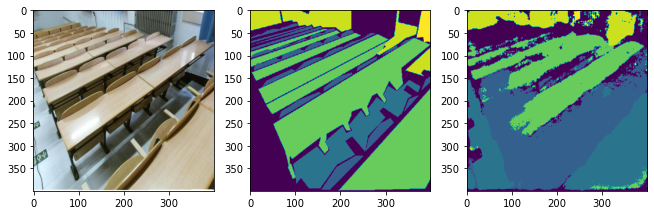

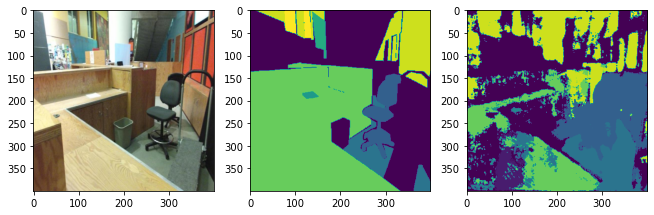

Training loss: 1.1374   Training accuracy: 0.6071   Training mIoU: 0.2894
Validation loss: 1.1297 Validation accuracy: 0.6109 Validation mIoU: 0.2896
--------------------------------------------------------
Running Epoch 17


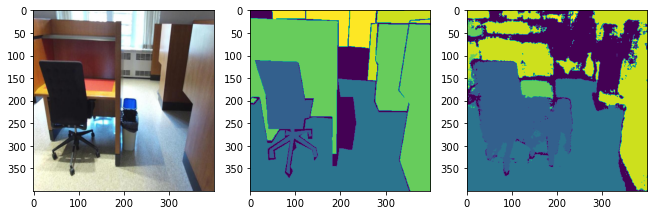

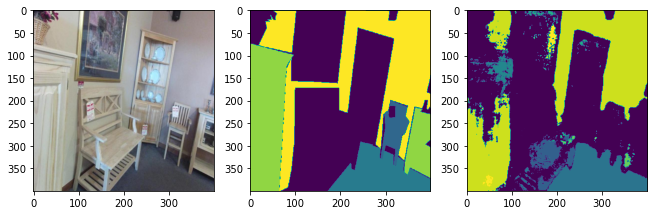

Training loss: 1.1206   Training accuracy: 0.6110   Training mIoU: 0.2981
Validation loss: 1.0975 Validation accuracy: 0.6200 Validation mIoU: 0.3042
--------------------------------------------------------
Running Epoch 18


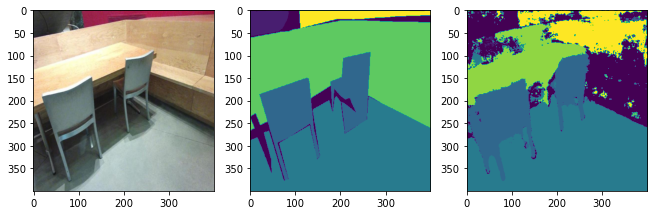

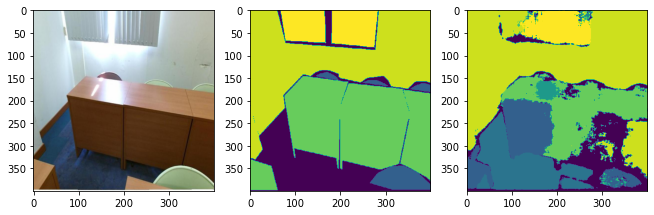

Training loss: 1.1001   Training accuracy: 0.6180   Training mIoU: 0.3073
Validation loss: 1.0938 Validation accuracy: 0.6233 Validation mIoU: 0.3095
--------------------------------------------------------
Running Epoch 19


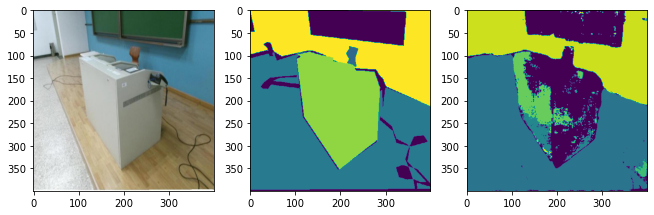

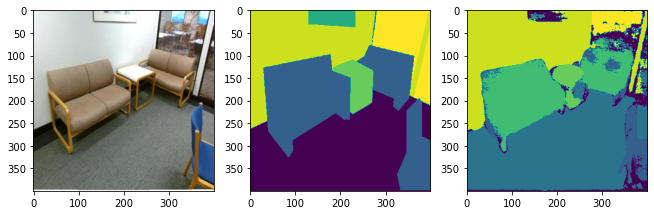

Training loss: 1.0838   Training accuracy: 0.6234   Training mIoU: 0.3182
Validation loss: 1.0989 Validation accuracy: 0.6211 Validation mIoU: 0.2990
--------------------------------------------------------
Running Epoch 20


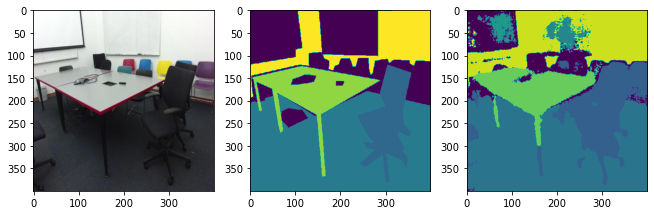

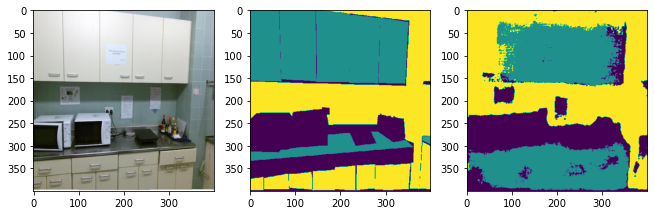

Training loss: 1.0659   Training accuracy: 0.6292   Training mIoU: 0.3243
Validation loss: 1.1502 Validation accuracy: 0.6100 Validation mIoU: 0.2980
--------------------------------------------------------
Running Epoch 21


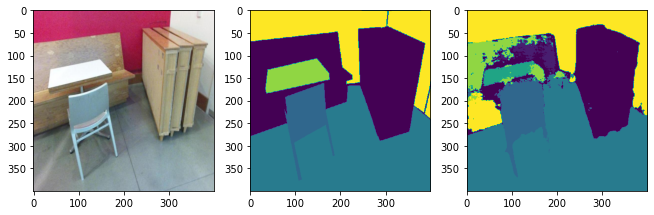

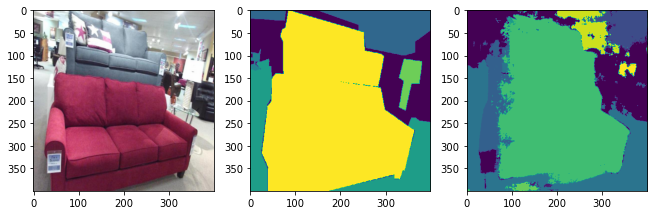

Training loss: 1.0466   Training accuracy: 0.6331   Training mIoU: 0.3334
Validation loss: 1.0654 Validation accuracy: 0.6303 Validation mIoU: 0.3109
--------------------------------------------------------
Running Epoch 22


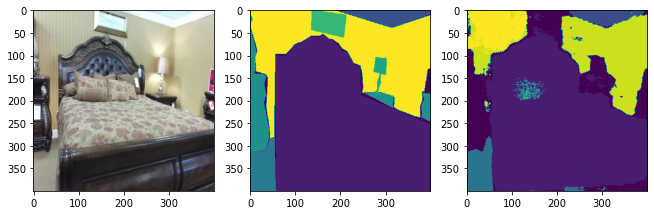

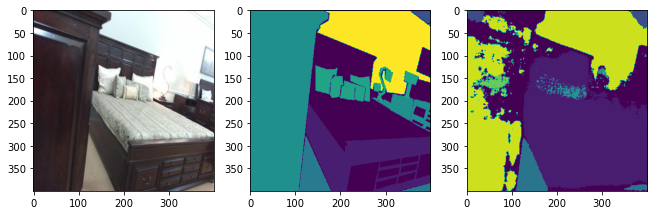

Training loss: 1.0335   Training accuracy: 0.6378   Training mIoU: 0.3397
Validation loss: 1.0818 Validation accuracy: 0.6227 Validation mIoU: 0.3115
--------------------------------------------------------
Running Epoch 23


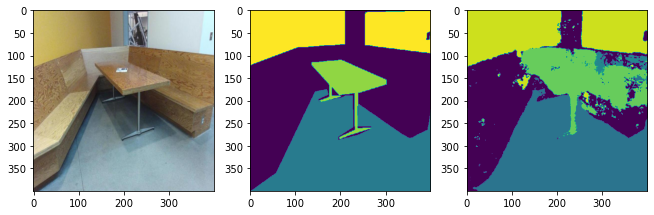

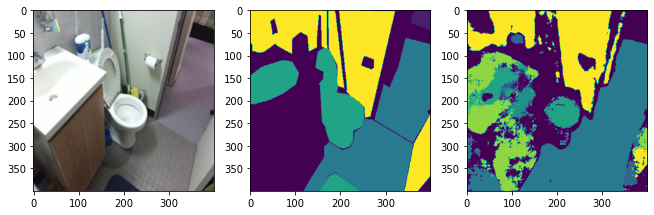

Training loss: 1.0033   Training accuracy: 0.6476   Training mIoU: 0.3538
Validation loss: 1.0345 Validation accuracy: 0.6422 Validation mIoU: 0.3303
--------------------------------------------------------
Running Epoch 24


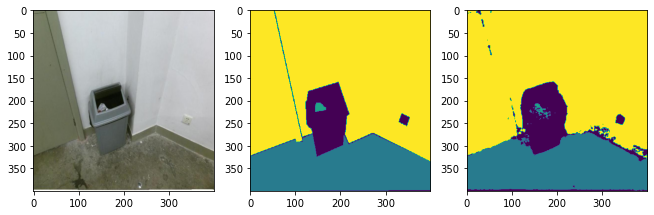

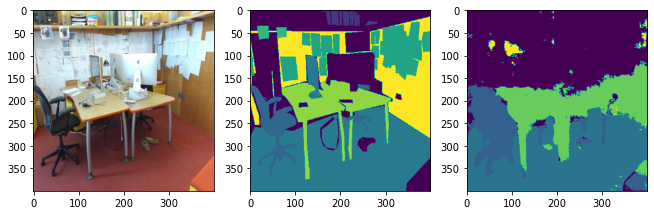

Training loss: 0.9969   Training accuracy: 0.6499   Training mIoU: 0.3565
Validation loss: 1.0385 Validation accuracy: 0.6375 Validation mIoU: 0.3406
--------------------------------------------------------
Running Epoch 25


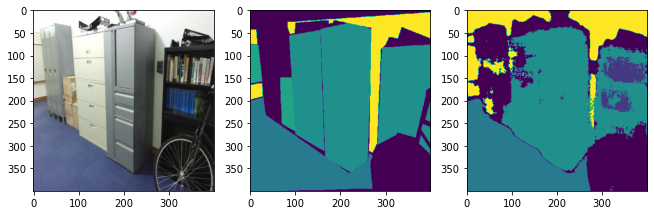

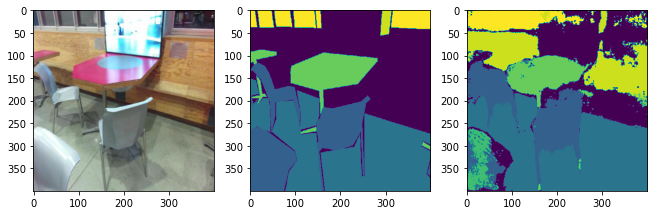

Training loss: 0.9780   Training accuracy: 0.6542   Training mIoU: 0.3646
Validation loss: 1.0814 Validation accuracy: 0.6257 Validation mIoU: 0.3247
--------------------------------------------------------
Running Epoch 26


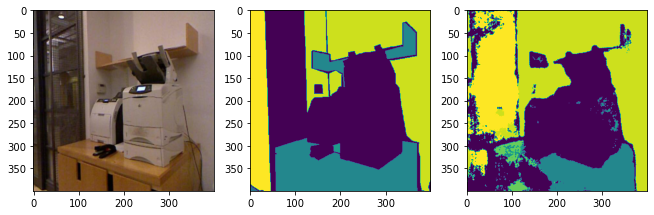

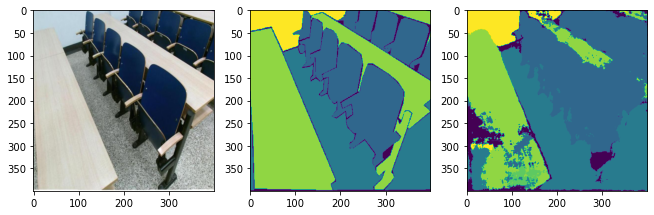

Training loss: 0.9584   Training accuracy: 0.6605   Training mIoU: 0.3737
Validation loss: 1.0579 Validation accuracy: 0.6384 Validation mIoU: 0.3444
--------------------------------------------------------
Running Epoch 27


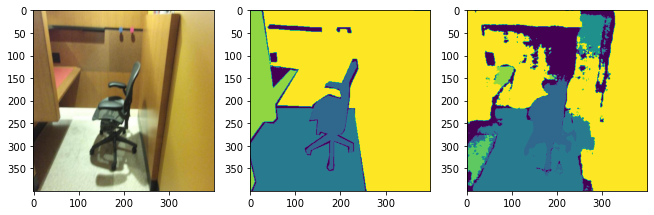

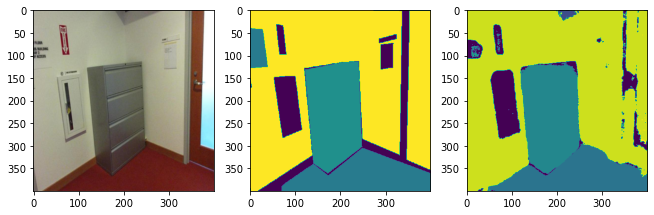

Training loss: 0.9468   Training accuracy: 0.6643   Training mIoU: 0.3813
Validation loss: 1.0592 Validation accuracy: 0.6338 Validation mIoU: 0.3374
--------------------------------------------------------
Running Epoch 28


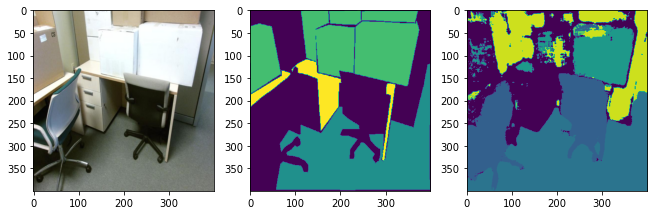

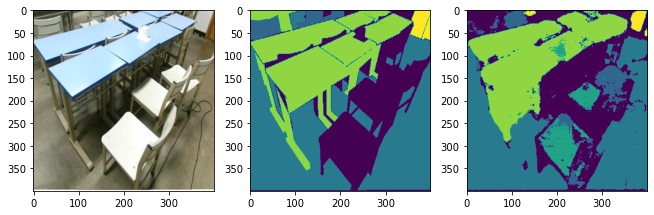

Training loss: 0.9278   Training accuracy: 0.6710   Training mIoU: 0.3909
Validation loss: 1.0878 Validation accuracy: 0.6267 Validation mIoU: 0.3265
--------------------------------------------------------
Running Epoch 29


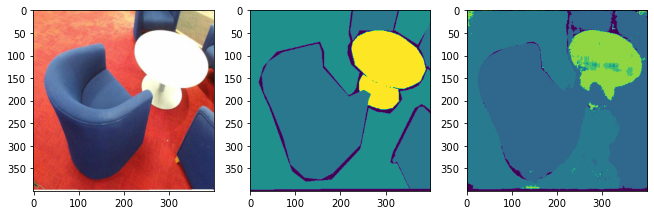

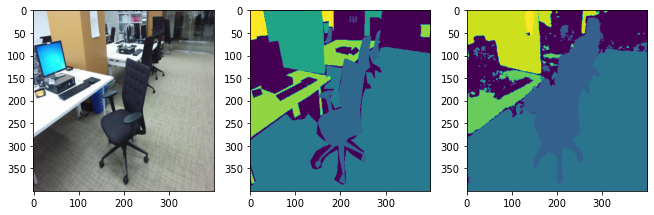

Training loss: 0.9047   Training accuracy: 0.6787   Training mIoU: 0.4045
Validation loss: 1.0685 Validation accuracy: 0.6377 Validation mIoU: 0.3407
--------------------------------------------------------
Running Epoch 30


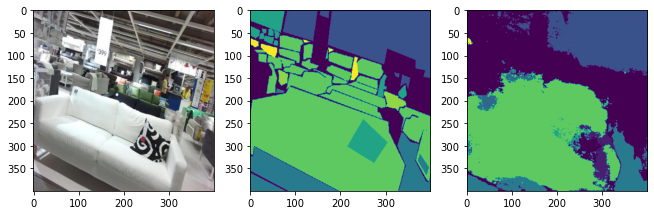

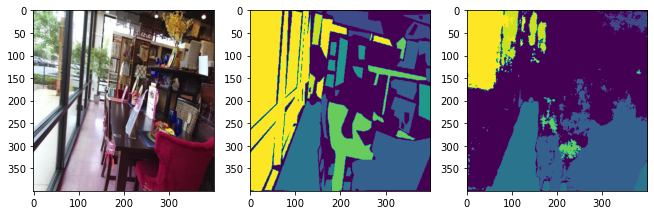

Training loss: 0.8948   Training accuracy: 0.6814   Training mIoU: 0.4095
Validation loss: 1.0734 Validation accuracy: 0.6342 Validation mIoU: 0.3254
--------------------------------------------------------
Early stopping
Training completed!


In [18]:
# train model
losses, accuracies, model = train_model(train_loader, val_loader)

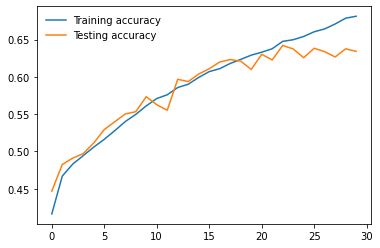

In [19]:

# plot trained metrics
loss_curve = "loss"
draw_training_curves(losses[0], losses[1],loss_curve)
loss_curve = "accuracy"
draw_training_curves(accuracies[0], accuracies[1],loss_curve)


In [29]:
test_loader = get_data_loader(data['test'], labels['test'],"test")
run_inference(test_loader)

Loading pre-trained weights...
Weights loaded!
Mean Pixel IoU:  tensor(0.3071, device='cuda:0')
Accuracy:  tensor(0.6096, device='cuda:0')
